In [2]:
#DIT MODEL IS GEBASSEERD OP DE PAPER VAN LIU.

#imports
import pandas as pd
import requests
import os
import numpy as np
!pip install python-igraph
import networkx as nx
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, make_scorer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import sys
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pu_learning import spies
from sklearn.base import clone
import time
import optuna



In [3]:

data = pd.read_csv("SAML-D_sampled_data.csv") 

data.tail()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
2999995,23:01:55,2023-06-03,6465028610,2172225510,155695.31,UK pounds,Dirham,UK,UAE,Cross-border,1,Single_large
2999996,08:14:29,2023-05-10,9634559331,8020264563,2481.04,UK pounds,UK pounds,UK,UK,Cash Deposit,1,Smurfing
2999997,22:05:45,2022-12-15,1240988490,4597902876,3119.80,UK pounds,Yen,UK,UK,Cheque,1,Structuring
2999998,22:17:46,2022-10-18,6770601554,6128626942,76.65,UK pounds,Naira,UK,Nigeria,Cash Withdrawal,1,Cash_Withdrawal
2999999,05:46:53,2023-04-05,8424086459,3934928194,4284.21,UK pounds,Albanian lek,UK,Albania,Cross-border,1,Deposit-Send


In [4]:
print(data["Is_laundering"].value_counts())

0    2996884
1       3116
Name: Is_laundering, dtype: int64


In [6]:

data['Hour'] = pd.to_datetime(data['Time']).dt.hour

data['Date_Year'] = pd.to_datetime(data['Date']).dt.year
data['Date_Month'] = pd.to_datetime(data['Date']).dt.month
data['Date_Day'] = pd.to_datetime(data['Date']).dt.day

data.drop(columns=['Laundering_type'], inplace=True)
data.drop(columns=['Time', 'Date'], inplace=True)




data.head()


,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Hour,Date_Year,Date_Month,Date_Day
0,5962016906,3377238139,5285.95,UK pounds,UK pounds,UK,UK,ACH,0,2,2023,6,2
1,985504393,8645656726,6703.57,UK pounds,UK pounds,UK,UK,ACH,0,17,2022,10,15
2,2012195326,8080878478,2999.20,UK pounds,UK pounds,UK,UK,Cash Deposit,0,9,2022,10,24
3,9696055743,1969723275,5844.41,UK pounds,UK pounds,UK,UK,Credit card,0,21,2022,12,16
4,9248338532,3039356124,9107.88,UK pounds,UK pounds,UK,UK,Credit card,0,16,2023,1,22


In [7]:

for col in ['Sender_account', 'Receiver_account']:
    data[col] = data[col].astype(str)
data.dropna(subset=["Sender_account", "Receiver_account"], inplace=True)

# Networkfeatures
G = nx.DiGraph()
edges = list(zip(data["Sender_account"], data["Receiver_account"], data["Amount"]))
G.add_weighted_edges_from(edges)

G_ig = ig.Graph.TupleList(edges, directed=True)
data["degree_centrality"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Sender_account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# timebased features
data["rolling_24h_amount"] = data.groupby("Sender_account")["Amount"]\
                                 .rolling(50).sum().reset_index(0, drop=True).fillna(0)
data["transaction_count"] = data.groupby("Sender_account")["Amount"].transform("count")

# Feature selection
features = data.drop(columns=[
    'Is_laundering',
    'rolling_24h_amount',
    'Sender_bank_location',
    'Payment_currency',
    'Received_currency'
]).copy()

# add features manually
features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]
features.drop(columns=['Date_Year', 'Date_Month'], inplace=True, errors='ignore')

# Target
target = data['Is_laundering']



In [8]:
# Train/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target, random_state=42
)

#  Train/validation split within train
X_train, X_val, y_train_true, y_val_true = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# categorical encoding
categorical_cols = ['Sender_account', 'Receiver_account', 'Payment_type', 'Date_Day']
encoders = {}
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    # Combine columns from train, validation, and test sets to see all unique values
    combined = pd.concat([X_train[col], X_val[col], X_test[col]]).astype(str)
    
    # Fit on the combined
    le.fit(combined)
    
    # Transform seperate
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    encoders[col] = le  


#  SCALING on numerical features
numerical_cols = ['Hour', 'Amount']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


<ipython-input-8-a79533a5feb8>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = le.transform(X_train[col].astype(str))
<ipython-input-8-a79533a5feb8>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = le.transform(X_val[col].astype(str))
<ipython-input-8-a79533a5feb8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Train shape: (1680000, 11)
Validation shape: (420000, 11)
Test shape: (900000, 11)


In [9]:

le = LabelEncoder()
combined = pd.concat([X_train["Receiver_bank_location"], X_val["Receiver_bank_location"], X_test["Receiver_bank_location"]]).astype(str)
le.fit(combined)

X_train["Receiver_bank_location"] = le.transform(X_train["Receiver_bank_location"].astype(str))
X_val["Receiver_bank_location"] = le.transform(X_val["Receiver_bank_location"].astype(str))
X_test["Receiver_bank_location"] = le.transform(X_test["Receiver_bank_location"].astype(str))





<ipython-input-9-923af7bb849b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Receiver_bank_location"] = le.transform(X_train["Receiver_bank_location"].astype(str))
<ipython-input-9-923af7bb849b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val["Receiver_bank_location"] = le.transform(X_val["Receiver_bank_location"].astype(str))
<ipython-input-9-923af7bb849b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [10]:


url = "https://raw.githubusercontent.com/trokas/pu_learning/master/pu_learning.py"
response = requests.get(url)
if response.status_code == 200:
    with open("pu_learning.py", "wb") as f:
        f.write(response.content)
else:
    raise Exception("Fout bij downloaden van pu_learning.py")

with open("pu_learning.py", "r") as f:
    lines = f.readlines()
corrected_lines = [line.replace(".values", "") for line in lines]
with open("pu_learning.py", "w") as f:
    f.writelines(corrected_lines)

sys.path.append(os.getcwd())



In [11]:
def maak_pu_setting_van_echte_labels(y_true, label_ratio, random_state=42):
   
    np.random.seed(random_state)

   
    positieve_indexen = np.where(y_true == 1)[0]
    n_gelabeld = int(label_ratio * len(positieve_indexen))
    gelabelde_indexen = np.random.choice(positieve_indexen, size=n_gelabeld, replace=False)

    y_pu = np.zeros_like(y_true)
    y_pu[gelabelde_indexen] = 1

    return y_pu, y_true, gelabelde_indexen




In [27]:
alpha = 0.001  # 0.1% echte positieven
label_ratio = 0.2  # 20% labeling probability (c)

y_train_pu, y_train_true, gelabelde_indexen = maak_pu_setting_van_echte_labels(y_train_true, label_ratio=0.5)


In [44]:
!pip install optuna

In [17]:


#def objective(trial):
 #   params = {
  #      "objective": "binary:logistic",
   #     "eval_metric": "logloss",
    #    "use_label_encoder": False,
     #  "n_estimators": trial.suggest_int("n_estimators", 50, 600),
      #  "max_depth": trial.suggest_int("max_depth", 3, 30),
       # "learning_rate": trial.suggest_float("learning_rate", 0.0004, 0.3, log=True),
        #"subsample": trial.suggest_float("subsample", 0.6, 1.0),
#        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
 #       "gamma": trial.suggest_float("gamma", 0.0, 5.0),
  #      "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
   #     "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    #    "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 20.0)
   # }

#    model = XGBClassifier(**params)
#    model.fit(X_train, y_train_true)

#    y_val_pred = model.predict(X_val)
#    score = f1_score(y_val_true, y_val_pred)
#    return score


#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=30, timeout=1200)
#print("Beste hyperparameters:", study.best_params)

# Gebruik beste model
#best_params = study.best_params
#best_params.update({
 #   "objective": "binary:logistic",
  #  "eval_metric": "logloss",
   # "use_label_encoder": False,
    #"tree_method": "hist"
#})
#xgb_best = XGBClassifier(**best_params)

[I 2025-05-10 20:06:15,648] A new study created in memory with name: no-name-5833ff38-b552-4ff0-99b1-f19e89b30274
[I 2025-05-10 20:06:47,443] Trial 0 finished with value: 0.4879614767255217 and parameters: {'n_estimators': 380, 'max_depth': 6, 'learning_rate': 0.20968664952873584, 'subsample': 0.8498246974121347, 'colsample_bytree': 0.8731110275653229, 'gamma': 3.2561382447050784, 'reg_alpha': 1.0233301657944016, 'reg_lambda': 4.455207882062772, 'scale_pos_weight': 7.369785650068486}. Best is trial 0 with value: 0.4879614767255217.
[I 2025-05-10 20:07:09,756] Trial 1 finished with value: 0.351555929352397 and parameters: {'n_estimators': 245, 'max_depth': 5, 'learning_rate': 0.09283028036167902, 'subsample': 0.67612423838154, 'colsample_bytree': 0.951801948177754, 'gamma': 1.2495589825857616, 'reg_alpha': 3.376368880483449, 'reg_lambda': 4.237527302433184, 'scale_pos_weight': 19.279688376597882}. Best is trial 0 with value: 0.4879614767255217.
[I 2025-05-10 20:07:52,839] Trial 2 finish

[I 2025-05-10 20:18:44,671] Trial 19 finished with value: 0.4887892376681614 and parameters: {'n_estimators': 597, 'max_depth': 7, 'learning_rate': 0.03496083788164799, 'subsample': 0.9902525073627726, 'colsample_bytree': 0.6847293789862776, 'gamma': 0.6826478066044497, 'reg_alpha': 5.953195593399904, 'reg_lambda': 5.474446609897004, 'scale_pos_weight': 8.005557660380884}. Best is trial 15 with value: 0.5051369863013699.
[I 2025-05-10 20:19:38,520] Trial 20 finished with value: 0.49056603773584906 and parameters: {'n_estimators': 484, 'max_depth': 10, 'learning_rate': 0.024383781898456986, 'subsample': 0.8615677790889338, 'colsample_bytree': 0.7763092056831801, 'gamma': 2.411666537715367, 'reg_alpha': 3.552599021908644, 'reg_lambda': 2.9996718418101693, 'scale_pos_weight': 15.611839034573569}. Best is trial 15 with value: 0.5051369863013699.
[I 2025-05-10 20:20:24,560] Trial 21 finished with value: 0.49916247906197664 and parameters: {'n_estimators': 555, 'max_depth': 10, 'learning_rat

Beste hyperparameters: {'n_estimators': 561, 'max_depth': 9, 'learning_rate': 0.043413384971344615, 'subsample': 0.916543280468344, 'colsample_bytree': 0.6895694372154403, 'gamma': 0.8102126801781209, 'reg_alpha': 3.9608945330633056, 'reg_lambda': 8.545704929094558, 'scale_pos_weight': 15.399565256999592}


In [28]:
#Beste hyperparameters: {'n_estimators': 561, 'max_depth': 9, 
#'learning_rate': 0.043413384971344615, 'subsample': 0.916543280468344, 'colsample_bytree': 0.6895694372154403, 
#'gamma': 0.8102126801781209, 'reg_alpha': 3.9608945330633056, 'reg_lambda': 8.545704929094558, 'scale_pos_weight': 15.399565256999592}


from xgboost import XGBClassifier

xgb_best = XGBClassifier(
    n_estimators=561,
    max_depth=9,
    learning_rate=0.043413384971344615,
    subsample=0.916543280468344,
    colsample_bytree=0.6895694372154403,
    gamma=0.8102126801781209,
    reg_alpha=3.9608945330633056,
    reg_lambda=8.545704929094558,
    scale_pos_weight=15.399565256999592,
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


# S-EM implementation
def spy_em(X, y, base_model, spy_ratio=0.2, spy_tolerance=0.05, max_iter=10, tol=1e-4, random_state=42):
    np.random.seed(random_state)
    positives = X[y == 1]   #SPIES PHASE: we assign the instances where y == 1 the label positives, and the rest are treated as unlabeled
    unlabeled = X[y == 0]

    spy_mask = np.random.rand(len(positives)) < spy_ratio   #  now we select spies from the positives
    spies = positives[spy_mask]   #These are the spies
    non_spy_positives = positives[~spy_mask]   #These are the positives that are not the spies 

    MS = np.vstack([unlabeled, spies]) # this is the Mixed unlabeled set incl. spies
    MS_labels = np.concatenate([np.zeros(len(unlabeled)), np.ones(len(spies))])   # # Spies get a temporary label
    MSP = np.vstack([MS, non_spy_positives])     # add to non-Spy positives to the mixed unlabeled set
    MSP_y = np.concatenate([MS_labels, np.ones(len(non_spy_positives))])

    model = clone(base_model)
    model.fit(MSP, MSP_y) #We train an initial model on the combined dataset MSP (which includes the spies, non-spy positives, and unlabeled instances)
    probs = model.predict_proba(MS)[:, 1] #we then predict for MS (spies + unlabeled) the probability that each instance is positive
    spy_labels = MS_labels == 1

    threshold = 0.001   ##You set a threshold such that at most a small percentage (e.g., 5%) of the spies fall below that threshold.
    while (probs[spy_labels] <= threshold).mean() <= spy_tolerance and threshold < 1.0:
        threshold += 0.001       #What remains (the truly unlabeled instances with low probability) is then considered as reliable negative examples.

    reliable_N = MS[(MS_labels == 0) & (probs <= threshold)]     #All instances in the original unlabeled set whose predicted probability of being positive falls below the threshold are included as reliable negative examples
    current_model = clone(base_model)
    prev_loss = None

    for iteration in range(max_iter):  #EM phase: You train a new model on the combination of the reliable negatives (label 0) and positives (label 1)
        
        start_time = time.time()
        print(f"[DEBUG] start_time net gezet: {start_time} ({type(start_time)})")

        # Training
        NP = np.vstack([reliable_N, positives])
        labels = np.concatenate([np.zeros(len(reliable_N)), np.ones(len(positives))])

        current_model.fit(
            NP, labels,
            eval_set=[(NP, labels)],
            early_stopping_rounds=10,
            verbose=False
        )

        # New predictions
        probs = current_model.predict_proba(MS)[:, 1]
        new_reliable_N = MS[(MS_labels == 0) & (probs <= threshold)]

        # DEBUG: check types before loss
        print(f"[DEBUG] reliable_N shape: {reliable_N.shape}, dtype: {getattr(reliable_N, 'dtype', 'nvt')}")
        print(f"[DEBUG] new_reliable_N shape: {new_reliable_N.shape}, dtype: {getattr(new_reliable_N, 'dtype', 'nvt')}")
        print(f"[DEBUG] reliable_N type: {type(reliable_N)}, new_reliable_N type: {type(new_reliable_N)}")

        # Loss-calculation
        try:
            if len(reliable_N) == len(new_reliable_N):
                loss = np.mean((reliable_N - new_reliable_N)**2)
            else:
                loss = np.inf
        except Exception as e:
            print(f"[ERROR tijdens loss-berekening] {e}")
            loss = np.inf

        # 
        try:
            duration = time.time() - start_time
        except Exception as e:
            print(f"[ERROR tijdens time()-start_time]: {e}")
            duration = "error"

        # Print loss + time
        print(f"Iteratie {iteration + 1}  duurde {duration}")
        print(f"DEBUG Iteratie {iteration + 1} - prev_loss: {prev_loss} ({type(prev_loss)}), loss: {loss} ({type(loss)})")

        # Converge
        if prev_loss is not None and isinstance(loss, float) and abs(prev_loss - loss) < tol:
            print(f"Geconvergeerd na {iteration+1} iteraties.")
            break

        reliable_N = new_reliable_N
        prev_loss = loss


    return current_model, threshold, reliable_N




In [29]:

# PU-training
final_model, best_thresh, reliable_negatives = spy_em(X_train, y_train_pu, xgb_best) 

# predictions
y_prob = final_model.predict_proba(X_test)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >=best_threshold).astype(int)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("Model evaluatie (S-EM): met threshold", best_threshold)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

[DEBUG] start_time net gezet: 1747145761.616898 (<class 'float'>)


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[DEBUG] reliable_N shape: (1679088, 11), dtype: float64
[DEBUG] new_reliable_N shape: (1679068, 11), dtype: float64
[DEBUG] reliable_N type: <class 'numpy.ndarray'>, new_reliable_N type: <class 'numpy.ndarray'>
Iteratie 1  duurde 91.97508502006531
DEBUG Iteratie 1 - prev_loss: None (<class 'NoneType'>), loss: inf (<class 'float'>)
[DEBUG] start_time net gezet: 1747145853.60431 (<class 'float'>)
[DEBUG] reliable_N shape: (1679068, 11), dtype: float64
[DEBUG] new_reliable_N shape: (1679053, 11), dtype: float64
[DEBUG] reliable_N type: <class 'numpy.ndarray'>, new_reliable_N type: <class 'numpy.ndarray'>
Iteratie 2  duurde 91.78738594055176
DEBUG Iteratie 2 - prev_loss: inf (<class 'float'>), loss: inf (<class 'float'>)
[DEBUG] start_time net gezet: 1747145945.405175 (<class 'float'>)
[DEBUG] reliable_N shape: (1679053, 11), dtype: float64
[DEBUG] new_reliable_N shape: (1679048, 11), dtype: float64
[DEBUG] reliable_N type: <class 'numpy.ndarray'>, new_reliable_N type: <class 'numpy.ndarra

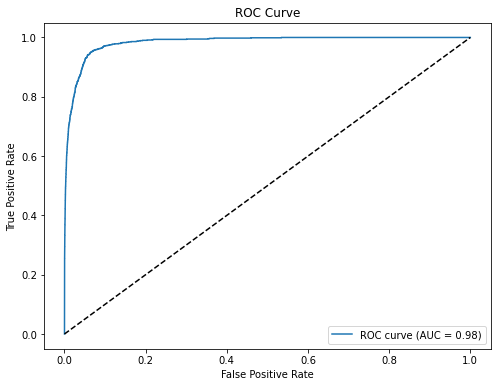

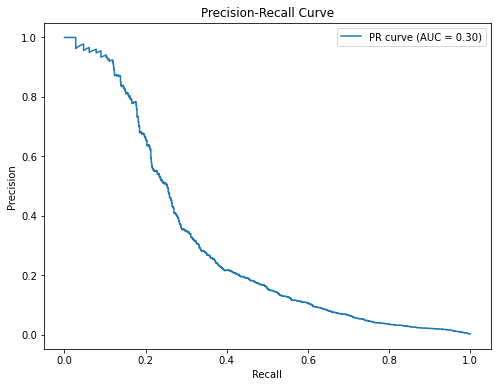

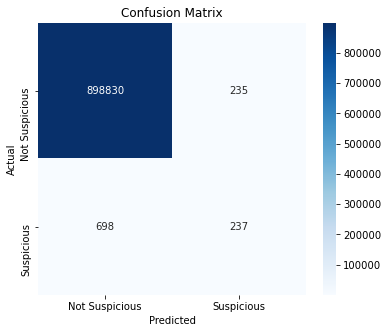

In [18]:
# ROC Curve 
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale lijn (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR Curve 
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

#  Confusion Matrix 
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspicious', 'Suspicious'], yticklabels=['Not Suspicious', 'Suspicious'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [37]:
print(X_test)

[['254285' '263609' -0.16572900159359596 ... 1.1048217118253602e-06 154
  15.268366488940574]
 ['224668' '433666' 0.04164330725816679 ... 1.1114338489697424e-06 49 0.0]
 ['259485' '93486' 0.304635284667469 ... 1.0957605050734606e-06 50 0.0]
 ...
 ['69788' '258797' -0.030805396675066644 ... 1.0865883987856823e-06 87
  0.0]
 ['214998' '133877' -0.21880500203544545 ... 1.0937730186738867e-06 112
  0.0]
 ['138853' '57880' 0.42686784770428904 ... 1.1283510122147523e-06 90 0.0]]


In [19]:
np.save("preds_S-EM.npy", y_pred)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

fpr_pu, tpr_pu, _ = roc_curve(y_test, y_prob)
auc_pu = roc_auc_score(y_test, y_prob)

np.savez("roc_S-EM.npz",
         fpr=fpr_pu,
         tpr=tpr_pu,
         auc=auc_pu,
         labels=y_test,
         scores=y_prob)